# COVID Parcel Business Analysis (Final Version)

### Objective
Analyze weekly parcel data from 2019–2020, cleaned and enriched with:
- CustomerGroup and YearWeek
- Parcel volume trends (Pre-COVID vs COVID)
- Customer classification
- Revenue estimation
- Visualizations and export summary

In [1]:

import pandas as pd
import matplotlib.pyplot as plt

# Load original raw file
df = pd.read_csv("COVID_Parcel_Business.csv")
df.head()


,FakeCustomerID,THE_YEAR,THE_WEEK,VOLUME
0,718117,2021,1,8
1,718117,2020,7,257
2,718117,2019,39,141
3,718117,2018,1,14
4,718117,2021,2,192


In [2]:

# Rename for consistency
df.rename(columns={
    "FakeCustomerID": "CustomerID",
    "THE_YEAR": "Year",
    "THE_WEEK": "Week",
    "VOLUME": "Parcels"
}, inplace=True)

# Add CustomerGroup based on ID hash
group_labels = ['Enterprise', 'Large', 'Medium', 'Small']
df['CustomerGroup'] = df['CustomerID'].apply(lambda x: group_labels[x % 4])

# Add YearWeek
df['YearWeek'] = df['Year'].astype(str) + '-W' + df['Week'].astype(str).str.zfill(2)

# Filter for analysis years only
df = df[df["Year"].isin([2019, 2020])]
df.head()


,CustomerID,Year,Week,Parcels,CustomerGroup,YearWeek
1,718117,2020,7,257,Large,2020-W07
2,718117,2019,39,141,Large,2019-W39
6,718117,2020,8,232,Large,2020-W08
7,718117,2020,10,229,Large,2020-W10
8,718117,2020,2,251,Large,2020-W02


In [3]:

pre_covid_weeks = list(range(1, 16))
covid_weeks = list(range(16, 54))

vol_2019_pre = df[(df["Year"] == 2019) & (df["Week"].isin(pre_covid_weeks))].groupby(["CustomerID", "CustomerGroup"])["Parcels"].sum().rename("Vol_2019_Pre")
vol_2020_pre = df[(df["Year"] == 2020) & (df["Week"].isin(pre_covid_weeks))].groupby(["CustomerID", "CustomerGroup"])["Parcels"].sum().rename("Vol_2020_Pre")
vol_2020_covid = df[(df["Year"] == 2020) & (df["Week"].isin(covid_weeks))].groupby(["CustomerID", "CustomerGroup"])["Parcels"].sum().rename("Vol_2020_COVID")

df_vol = pd.concat([vol_2019_pre, vol_2020_pre, vol_2020_covid], axis=1).fillna(0).reset_index()

total_2019_pre = df_vol["Vol_2019_Pre"].sum()
total_2020_pre = df_vol["Vol_2020_Pre"].sum()
ISGR = round(((total_2020_pre - total_2019_pre) / total_2019_pre) * 100, 2)
print("ISGR =", ISGR)


ISGR = 11.4


In [4]:

def classify(row):
    if row['Vol_2019_Pre'] == 0 and row['Vol_2020_Pre'] == 0 and row['Vol_2020_COVID'] > 0:
        return 'New'
    elif row['Vol_2020_COVID'] == 0 and (row['Vol_2019_Pre'] > 0 or row['Vol_2020_Pre'] > 0):
        return 'Lost'
    elif row['Vol_2020_Pre'] == 0:
        return 'New' if row['Vol_2020_COVID'] > 0 else 'Lost'
    else:
        growth = ((row['Vol_2020_COVID'] - row['Vol_2020_Pre']) / row['Vol_2020_Pre']) * 100
        if growth > ISGR:
            return 'High Growth'
        elif 0 <= growth <= ISGR:
            return 'Stable'
        else:
            return 'Declining'

df_vol["CustomerStatus"] = df_vol.apply(classify, axis=1)
df_vol["Estimated_Revenue_COVID"] = df_vol["Vol_2020_COVID"] * 22
df_vol["CustomerStatus"].value_counts()


,count
CustomerStatus,
High Growth,941
Declining,73
Lost,28
Stable,10
New,7


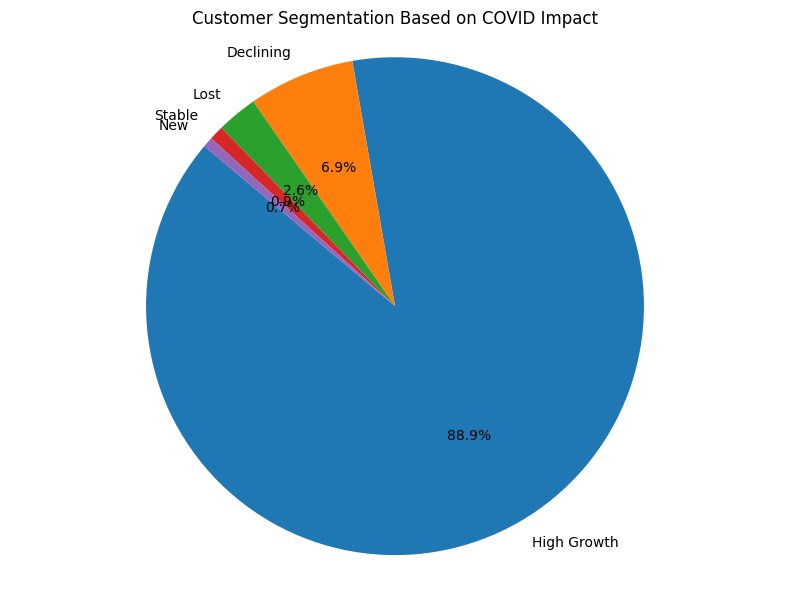

In [5]:

status_counts = df_vol["CustomerStatus"].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Customer Segmentation Based on COVID Impact")
plt.axis('equal')
plt.tight_layout()
plt.show()


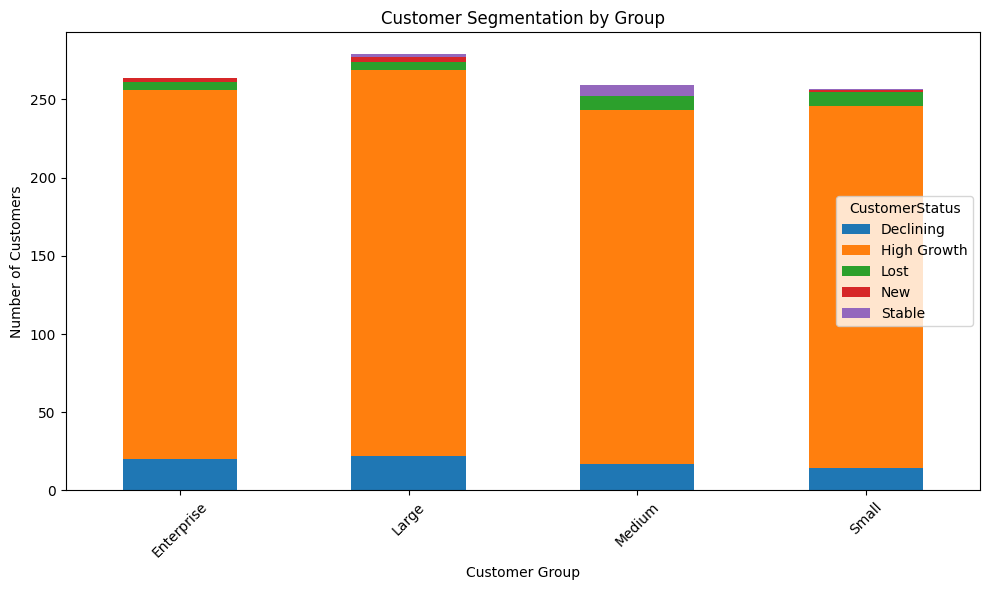

In [6]:

group_summary = df_vol.groupby(["CustomerGroup", "CustomerStatus"]).size().unstack(fill_value=0)
group_summary.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Customer Segmentation by Group")
plt.ylabel("Number of Customers")
plt.xlabel("Customer Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-10-98507fd7a394>:35: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


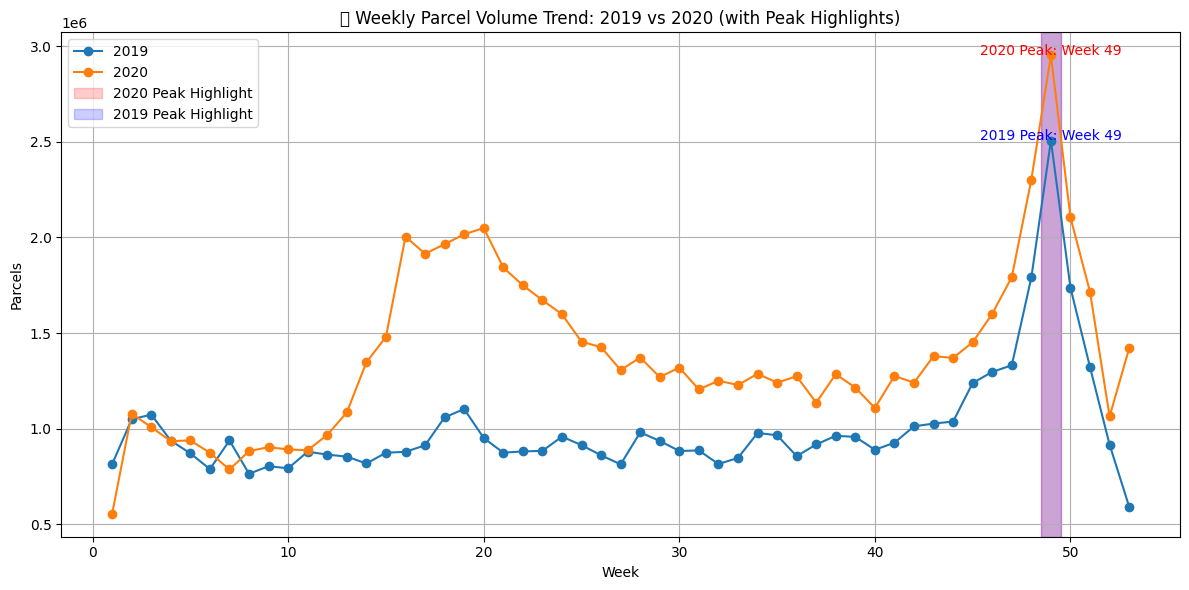

In [10]:
# Compute weekly trend
weekly_trend = df.groupby(["Year", "Week"])["Parcels"].sum().reset_index()

# Identify peak weeks
peak_2020 = weekly_trend[weekly_trend["Year"] == 2020].sort_values("Parcels", ascending=False).iloc[0]
peak_2019 = weekly_trend[weekly_trend["Year"] == 2019].sort_values("Parcels", ascending=False).iloc[0]

# Plot with highlighted rectangles
plt.figure(figsize=(12, 6))

for year in [2019, 2020]:
    data = weekly_trend[weekly_trend["Year"] == year]
    plt.plot(data["Week"], data["Parcels"], marker='o', label=str(year))

# Highlight peak week with rectangle (2020)
plt.axvspan(peak_2020["Week"] - 0.5, peak_2020["Week"] + 0.5,
            color='red', alpha=0.2, label='2020 Peak Highlight')
plt.text(peak_2020["Week"], peak_2020["Parcels"] + 2500,
         f'2020 Peak: Week {int(peak_2020["Week"])}',
         color='red', ha='center')

# Highlight peak week with rectangle (2019)
plt.axvspan(peak_2019["Week"] - 0.5, peak_2019["Week"] + 0.5,
            color='blue', alpha=0.2, label='2019 Peak Highlight')
plt.text(peak_2019["Week"], peak_2019["Parcels"] + 2500,
         f'2019 Peak: Week {int(peak_2019["Week"])}',
         color='blue', ha='center')

# Final formatting
plt.title("📈 Weekly Parcel Volume Trend: 2019 vs 2020 (with Peak Highlights)")
plt.xlabel("Week")
plt.ylabel("Parcels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:

df_export = df_vol[[
    "CustomerID", "CustomerGroup", "Vol_2019_Pre", "Vol_2020_Pre", "Vol_2020_COVID",
    "CustomerStatus", "Estimated_Revenue_COVID"
]]
df_export.to_excel("COVID_Parcel_Final_Summary.xlsx", index=False)
df_export.head()


,CustomerID,CustomerGroup,Vol_2019_Pre,Vol_2020_Pre,Vol_2020_COVID,CustomerStatus,Estimated_Revenue_COVID
0,100771,Small,442.0,448.0,1341.0,High Growth,29502.0
1,102180,Enterprise,1365.0,828.0,3989.0,High Growth,87758.0
2,102643,Small,745.0,599.0,1104.0,High Growth,24288.0
3,102750,Medium,344.0,196.0,209.0,Stable,4598.0
4,103308,Enterprise,19560.0,23748.0,79952.0,High Growth,1758944.0


### Summary
- Cleaned and enriched dataset
- Volume comparison and customer classification
- Estimated revenue per customer
- Final Excel export for business use